In [3]:
import sys
sys.path.append("../../")
import copy
import time

import numpy as np
import jax
jax.config.update("jax_enable_x64", True)
import optax

from fbpinns.problems import HarmonicOscillator1D
from fbpinns.domains import RectangularDomainND
from fbpinns.decompositions import RectangularDecompositionND, MultilevelRectangularDecompositionND
from fbpinns.constants import Constants, get_subdomain_ws
from fbpinns.trainers import FBPINNTrainer, PINNTrainer
from fbpinns.networks import FCN
from fbpinns.schedulers import AllActiveSchedulerND

from elm.elms import ELM
from elm.trainers import ELMFBPINNTrainer
from elm.optimisers import BlockRRQRLinearSolver
from elm.solvers import sps_lsqr

sys.path.append("../")
from problems import HarmonicOscillatorELM1D

def run_ELMFBPINN():
    run = f"ELMFBPINN_{tag}_{problem.__name__}_{network.__name__}_{l}-levels_{w}-overlap_{h}-layers_{p}-hidden_{n[0]}-n_{optimiser.__name__}-{optimiser_kwargs['system']}-{optimiser_kwargs['solver'].__name__}-{seed}"
    c = Constants(
        run=run,
        domain=domain,
        domain_init_kwargs=domain_init_kwargs,
        problem=problem,
        problem_init_kwargs=problem_init_kwargs,
        decomposition=MultilevelRectangularDecompositionND,
        decomposition_init_kwargs = dict(
                    subdomain_xss=subdomain_xss,
                    subdomain_wss=subdomain_wss,
                    unnorm=unnorm,
                    ),
        network=network,
        network_init_kwargs=network_init_kwargs,
        n_steps=n_steps,
        scheduler=scheduler,
        scheduler_kwargs=scheduler_kwargs,
        ns=(n,),
        n_test=n_test,
        optimiser=optimiser,
        optimiser_kwargs=optimiser_kwargs,
        seed=seed,
        test_freq=test_freq,
        model_save_freq=model_save_freq,
        show_figures=False,
        )
    return c, "ELMFBPINN"


def run_FBPINN():
    run = f"FBPINN_{tag}_{problem.__name__}_{network.__name__}_{l}-levels_{w}-overlap_{h}-layers_{p}-hidden_{n[0]}-n_{lr}-lr-{seed}"
    c = Constants(
        run=run,
        domain=domain,
        domain_init_kwargs=domain_init_kwargs,
        problem=problem,
        problem_init_kwargs=problem_init_kwargs,
        decomposition=MultilevelRectangularDecompositionND,
        decomposition_init_kwargs = dict(
                    subdomain_xss=subdomain_xss,
                    subdomain_wss=subdomain_wss,
                    unnorm=unnorm,
                    ),
        network=network,
        network_init_kwargs=network_init_kwargs,
        n_steps=n_steps,
        scheduler=scheduler,
        scheduler_kwargs=scheduler_kwargs,
        ns=(n,),
        n_test=n_test,
        optimiser=optimiser,
        optimiser_kwargs=optimiser_kwargs,
        seed=seed,
        test_freq=test_freq,
        model_save_freq=model_save_freq,
        show_figures=False,
        )
    return c, "FBPINN"


def run_PINN():
    run = f"PINN_{tag}_{problem.__name__}_{network.__name__}_{h}-layers_{p}-hidden_{n[0]}-n_{lr}-lr-{seed}"
    c = Constants(
        run=run,
        domain=domain,
        domain_init_kwargs=domain_init_kwargs,
        problem=problem,
        problem_init_kwargs=problem_init_kwargs,
        decomposition=RectangularDecompositionND,
        decomposition_init_kwargs = dict(
                    subdomain_xs=subdomain_xss[-1],
                    subdomain_ws=subdomain_wss[-1],
                    unnorm=unnorm,
                    ),
        network=network,
        network_init_kwargs=network_init_kwargs,
        n_steps=n_steps,
        ns=(n,),
        n_test=n_test,
        optimiser=optimiser,
        optimiser_kwargs=optimiser_kwargs,
        seed=seed,
        test_freq=test_freq,
        model_save_freq=model_save_freq,
        show_figures=False,
        )
    return c, "PINN"

runs=[]


optimisers = [
(optax.adam,
 dict(
    ),
 run_PINN),
(optax.adam,
 dict(
    ),
run_FBPINN),
(BlockRRQRLinearSolver,
 dict(system="least-squares",
      solver=sps_lsqr,
      solver_kwargs=dict(conlim=0),
      ),
    run_ELMFBPINN),
]

runs = []
for optimiser,optimiser_kwargs,run_fn in optimisers:

    sigma=1e-8
    network=ELM
    h=1
    p=8
    weight_scale=1
    w0=60
    w=2.3
    m=10
    seed=0
    
    if run_fn == run_ELMFBPINN:
        problem=HarmonicOscillatorELM1D
    else:
        problem=HarmonicOscillator1D
    problem_init_kwargs=dict(
        d=2, w0=w0,
    )
    domain=RectangularDomainND
    domain_init_kwargs=dict(xmin=np.array([0.]),
                            xmax=np.array([1.]),)
    l = 1
    subdomain_xss=[[np.linspace(0,1, m)]]
    subdomain_wss=[get_subdomain_ws(subdomain_xss[0], w)]
    unnorm=(0.,1.)
    n = ((p+1)*m,)
    n_test = (50*m,)
    if run_fn != run_ELMFBPINN:
        network = FCN
    if run_fn == run_PINN:
        h,p = 2, 64
    layer_sizes = [1,] + [p,]*h + [1,]
    if run_fn == run_ELMFBPINN:
        network_init_kwargs = dict(layer_sizes=layer_sizes, weight_scale=weight_scale)
    else:
        network_init_kwargs = dict(layer_sizes=layer_sizes)
    scheduler = AllActiveSchedulerND
    scheduler_kwargs = dict()
    if run_fn == run_ELMFBPINN:
        optimiser_kwargs["sigma"] = sigma
        tag = f"main-{w0}-w0_{m}-m_sigma-{sigma}_ws-{weight_scale}"
    else:
        lr = 1e-3
        optimiser_kwargs["learning_rate"] = lr
        tag = f"main-{w0}-w0_{m}-m"
        
    test_freq = 10000
    model_save_freq = 10000
    n_steps = 10000
    if run_fn == run_ELMFBPINN:
        optimiser_kwargs["save_results"] = False
    runs.append(run_fn())

trainers = dict(FBPINN=FBPINNTrainer,
                PINN=PINNTrainer,
                ELMFBPINN=ELMFBPINNTrainer)
for c,k in runs:
    run = trainers[k](c)
    run.train()

[INFO] 2025-11-23 22:16:07 - <fbpinns.constants.Constants object at 0x185cf4fc0>
run: PINN_main-60-w0_10-m_HarmonicOscillator1D_FCN_2-layers_64-hidden_90-n_0.001-lr-0
domain: <class 'fbpinns.domains.RectangularDomainND'>
domain_init_kwargs: {'xmin': array([0.]), 'xmax': array([1.])}
problem: <class 'fbpinns.problems.HarmonicOscillator1D'>
problem_init_kwargs: {'d': 2, 'w0': 60}
decomposition: <class 'fbpinns.decompositions.RectangularDecompositionND'>
decomposition_init_kwargs: {'subdomain_xs': [array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])], 'subdomain_ws': [array([0.25555556, 0.25555556, 0.25555556, 0.25555556, 0.25555556,
       0.25555556, 0.25555556, 0.25555556, 0.25555556, 0.25555556])], 'unnorm': (0.0, 1.0)}
network: <class 'fbpinns.networks.FCN'>
network_init_kwargs: {'layer_sizes': [1, 64, 64, 1]}
n_steps: 10000
scheduler: <class 'fbpinns.schedulers.AllActiveSchedulerND'>
scheduler_kwargs:

[INFO] 2025-11-23 22:16:27 - Loading model from:
results/models/ELMFBPINN_main-60-w0_10-m_sigma-1e-08_ws-1_HarmonicOscillatorELM1D_ELM_1-levels_2.3-overlap_1-layers_8-hidden_90-n_BlockRRQRLinearSolver-least-squares-sps_lsqr-0/model_00010000.jax
[INFO] 2025-11-23 22:16:27 - Loading model from:
results/models/FBPINN_main-60-w0_10-m_HarmonicOscillator1D_FCN_1-levels_2.3-overlap_1-layers_8-hidden_90-n_0.001-lr-0/model_00010000.jax
[INFO] 2025-11-23 22:16:27 - Loading model from:
results/models/PINN_main-60-w0_10-m_HarmonicOscillator1D_FCN_2-layers_64-hidden_90-n_0.001-lr-0/model_00010000.jax
[INFO] 2025-11-23 22:16:28 - x_batch
[INFO] 2025-11-23 22:16:28 - (500, 1), float64, ArrayImpl
[INFO] 2025-11-23 22:16:28 - x_take
[INFO] 2025-11-23 22:16:28 - (1132, 1), float64, ArrayImpl


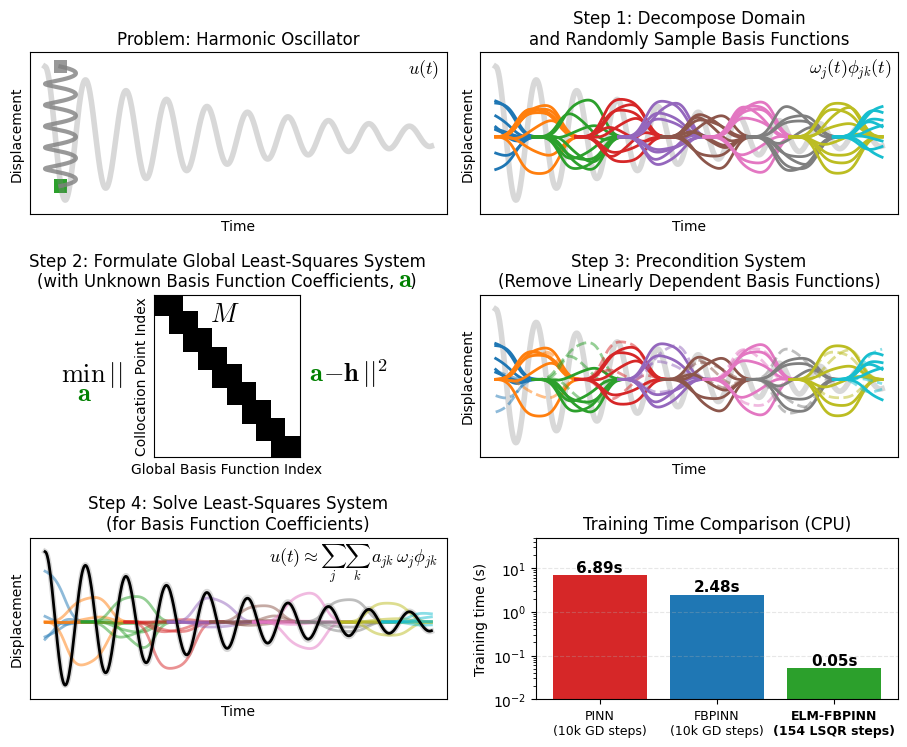

In [4]:
import matplotlib.pyplot as plt
params = {'text.usetex': False, 'mathtext.fontset': 'cm'}
plt.rcParams.update(params)

from fbpinns.util.other import colors

from plot import load_FBPINN, load_ELMFBPINN, load_PINN, exact_solution, FBPINN_solution
rootdir = "results/"

# get ELM-FBPINN domain decomposition, basis functions and exact solution

(optimiser,optimiser_kwargs,run_fn) = optimisers[2]
sigma=1e-8
network=ELM
h=1
p=8
weight_scale=1
w0=60
w=2.3
m=10
seed=0

tag = f"main-{w0}-w0_{m}-m_sigma-{sigma}_ws-{weight_scale}"
problem=HarmonicOscillatorELM1D
l=1
n = ((p+1)*m,)
n_test = (50*m,)
lr=1e-3

c, model, i, t, l1n = load_ELMFBPINN(tag, problem, network, l, w, h, p, n, lr, seed, optimiser, optimiser_kwargs, rootdir)

def load_npz(file):
    return (lambda f: [f[k] for k in f.files])(np.load(file))

info = load_npz(f"{rootdir}summaries/{c.run}/info.npz")
t_ELMFBPINN = t[-1]-info[1][0][1]# Training time (without assembly)
t_FBPINN = load_FBPINN(f"main-{w0}-w0_{m}-m", HarmonicOscillator1D, FCN, l, w, h, p, n, lr, seed, rootdir="results/")[3]
t_FBPINN = t_FBPINN[-1]-t_FBPINN[0]# Training time
t_PINN = load_PINN(f"main-{w0}-w0_{m}-m", HarmonicOscillator1D, FCN, 2, 64, n, lr, seed, rootdir="results/")[3]
t_PINN = t_PINN[-1]-t_PINN[0]# Training time

# get exact solution
u_exact = exact_solution(c, model)
u = FBPINN_solution(c, model)
t = np.linspace(0,1,u_exact.shape[0])

# get basis functions
all_params = model[1]
x = t.reshape(n_test+(1,))
domain, problem, decomposition = c.domain, c.problem, c.decomposition
def basis_fn(all_params, x, norm_fn, window_fn):
    w = window_fn(all_params, x)
    x = norm_fn(all_params, x)
    x = c.network.basis_fn(all_params, x)
    return x,w
d = all_params
f = {t_k: {cl_k: {k: jax.tree_util.tree_map(lambda p: 0, d[t_k][cl_k][k]) if k=="subdomain" else jax.tree_util.tree_map(lambda p: None, d[t_k][cl_k][k])
    for k in d[t_k][cl_k]}
    for cl_k in d[t_k]}
    for t_k in ["static", "trainable"]}
b,w = jax.vmap(jax.vmap(basis_fn, in_axes=(f,None,None,None)), in_axes=(None, 0, None, None))(
    all_params, x, decomposition.norm_fn, decomposition.window_fn)# (N, J, C)
w = w/w.sum(axis=1, keepdims=True)# apply POU
N, J, C = b.shape
a = model[1]["trainable"]["network"]["subdomain"]["basis_coeffs"]# (J, 1, C)

# get domain decomposition
xs = c.decomposition_init_kwargs["subdomain_xss"][0][0]
ws = c.decomposition_init_kwargs["subdomain_wss"][0][0]



# training times
methods = [
    "PINN\n(10k GD steps)",
    "FBPINN\n(10k GD steps)",
    f"ELM-FBPINN\n({info[0]} LSQR steps)"
]
times = [
    t_PINN, t_FBPINN, t_ELMFBPINN,
]
cs = [
    "tab:red",
    "tab:blue",
    "tab:green",
]

def spring(H, r, n_cycles, n_samples=100):
    t0,t1 = -0.5*np.pi, (2*n_cycles+0.5)*np.pi
    t = np.linspace(t0,t1,1000)
    h = (-2*H-r*(np.sin(t1)-np.sin(t0)))/(t1-t0)# fit length of coil to H
    x = r*np.cos(t)
    y = r*np.sin(t)
    z = h*t# equation for a helix
    c = -(h*t0+r*np.sin(t0))/2# shift origin to zero
    x,y = x,-((z+y)/2+c)# transform pov
    return x,y

H = -1.7
sx,sy = spring(H=H, r=0.04, n_cycles=5)



# MAKE COMPOSITE PLOT

plt.figure(figsize=0.7*np.array([16,12]))
xlim=(-0.04,1.04)
ylim=(-1.1,1.2)

# problem
plt.subplot(3,2,1)
plt.title("Problem: Harmonic Oscillator")
plt.plot(t, u_exact, color="tab:grey", lw=4, alpha=0.3)
plt.scatter(0.04,H+1,marker="s", s=100, facecolor="tab:green", edgecolor="none", linewidth=3, alpha=1)
plt.scatter(0.04,0+1,marker="s", s=100, facecolor="grey", edgecolor="none", linewidth=3, alpha=0.8)
plt.plot(0.04+sx,sy+1, "grey", linewidth=3, alpha=0.8)
plt.text(0.94, 0.9, r"$u(t)$", fontsize=13)
plt.xlabel("Time"); plt.ylabel("Displacement")
plt.xticks([]); plt.yticks([])
plt.xlim(*xlim); plt.ylim(*ylim)

# basis
plt.subplot(3,2,2)
plt.title("Step 1: Decompose Domain\nand Randomly Sample Basis Functions")
plt.plot(t, u_exact, color="tab:grey", lw=4, alpha=0.3)
for j in range(J):
    for k in range(1,b.shape[2]):
        fm = ((x >= (xs-ws/2)[j]) & (x <= (xs+ws/2)[j]))[:,0]
        plt.plot(x[fm], 0.7*w[fm,j,k]*b[fm,j,k], 
                 color=colors[j], lw=2)
plt.text(0.81, 0.9, r"$\omega_j(t)\phi_{jk}(t)$", fontsize=13)
plt.xlabel("Time"); plt.ylabel("Displacement")
plt.xticks([]); plt.yticks([])
plt.xlim(*xlim); plt.ylim(*ylim)

# precond
plt.subplot(3,2,4)
plt.title("Step 3: Precondition System\n(Remove Linearly Dependent Basis Functions)")
plt.plot(t, u_exact, color="tab:grey", lw=4, alpha=0.3)
for j in range(J):
    for k in range(1,b.shape[2]):
        fm = ((x >= (xs-ws/2)[j]) & (x <= (xs+ws/2)[j]))[:,0]
        plt.plot(x[fm], 0.7*w[fm,j,k]*b[fm,j,k], "--" if k<4 else "-", 
                 color=colors[j], lw=2, alpha=0.5 if k<4 else None)
plt.xlabel("Time"); plt.ylabel("Displacement")
plt.xticks([]); plt.yticks([])
plt.xlim(*xlim); plt.ylim(*ylim)

# final solution
plt.subplot(3,2,5)
plt.title("Step 4: Solve Least-Squares System\n(for Basis Function Coefficients)")
plt.plot(t, u_exact, color="tab:grey", lw=4, alpha=0.3)
for j in range(J):
    for k in range(1,b.shape[2]):
        fm = ((x >= (xs-ws/2)[j]) & (x <= (xs+ws/2)[j]))[:,0]
        plt.plot(x[fm], 0.7*(np.exp(-2*x[fm]).mean())*w[fm,j,k]*b[fm,j,k]*(a[j,:,k]/np.abs(a[j]).mean()), # normalise weights for nice plotting
                 color=colors[j], lw=2, alpha=0 if k<4 else 0.5)
plt.plot(t, u, color="k", lw=2)
plt.text(0.58, 0.86, r"$u(t) \approx \sum_j \sum_k \, a_{jk}\, \omega_j\phi_{jk}$", fontsize=13)
plt.xlabel("Time"); plt.ylabel("Displacement")
plt.xticks([]); plt.yticks([])
plt.xlim(*xlim); plt.ylim(*ylim)

plt.subplots_adjust(hspace=0.5, wspace=0.08)

# linear system
ax = plt.subplot(3,2,3)
plt.title("Step 2: Formulate Global Least-Squares System\n(with Unknown Basis Function Coefficients,   )", x=0.5)
plt.text(150, -27.5, r"$\mathbf{a}$", fontsize=19, color="green")
plt.text(34,80,"$M$", fontsize=19)
plt.spy((w*b).reshape(w.shape[0],-1), aspect=0.2)
plt.xlabel("Global Basis Function Index")
plt.ylabel("Collocation Point Index")
plt.xticks([]); plt.yticks([])
plt.text(95, 263, r"$\mathbf{a}$", fontsize=19, color="green")
plt.text(95 + 9, 265, r"$-\mathbf{h}\,||^2$", fontsize=19)
plt.text(-58,265,r"$\min\,||$", fontsize=19)
plt.text(-48, 325, r"$\mathbf{a}$", fontsize=19, color="green")
pos = ax.get_position()
ax.set_position([pos.x0 - 0.01, pos.y0, pos.width, pos.height])

ax = plt.subplot(3,2,6)
bars = plt.bar(methods, times, color=cs, edgecolor='none', linewidth=0)
for bar, t in zip(bars, times):
    plt.text(bar.get_x() + bar.get_width()/2, t,
             f"{t:.2f}s", ha='center', va='bottom', fontsize=11, fontweight='bold')
plt.ylabel("Training time (s)")
plt.title("Training Time Comparison (CPU)")
plt.xticks(fontsize=9)
plt.gca().get_xticklabels()[2].set_fontweight("bold")
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.yscale("log")
plt.ylim(1e-2,5e1)
pos = ax.get_position()
ax.set_position([pos.x0 + 0.05, pos.y0, pos.width-0.05, pos.height])

plt.savefig(f"paper-summary.png", bbox_inches='tight', pad_inches=0.1, dpi=200, facecolor="white")
plt.show()